In [1]:
# ============================================================================
# STEP 1: ENVIRONMENT SETUP
# ============================================================================
# Load environment variables and initialize Google Earth Engine

from dotenv import load_dotenv
load_dotenv()

import ee, eemont
from forestry_carbon_arr.core import ForestryCarbonARR
from forestry_carbon_arr.utils.zarr_utils import save_dataset_efficient_zarr, load_dataset_zarr

import gcsfs
import os

fs = gcsfs.GCSFileSystem(project=os.getenv("GOOGLE_CLOUD_PROJECT"), token='/usr/src/app/user_id.json')

forestry = ForestryCarbonARR(config_path='./00_input/korindo.json')
forestry.initialize_gee()

✓ GEE Initialized successfully
  Credentials Path: /usr/src/app/user_id.json - loaded successfully


In [2]:
# ============================================================================
# STEP 2: LOAD AREA OF INTEREST (AOI) but only on the AOI concession
# ============================================================================
# Load the area of interest geometry for reference

from forestry_carbon_arr.core.utils import DataUtils
import geopandas as gpd
import geemap

data_utils = DataUtils(forestry.config, use_gee=True)
aoi_gpd, aoi_ee = data_utils.load_geodataframe_gee('./00_input/korindo_buffer.shp')

aoi_gpd_utm = aoi_gpd.to_crs(epsg=32749)

print(f"✅ AOI loaded: {len(aoi_gpd_utm)} features")
print(f"   Area: {aoi_gpd_utm.geometry.area.sum()/10000:.2f} hectares")

✅ AOI loaded: 1 features
   Area: 40740.66 hectares


In [3]:
import importlib, forestry_carbon_arr.ML.inference as fc_infer, forestry_carbon_arr
import importlib, forestry_carbon_arr, forestry_carbon_arr.ML.inference as fc_infer 
importlib.reload(fc_infer)          # reload the inference module
importlib.reload(forestry_carbon_arr) 
from forestry_carbon_arr import load_model, save_config_ml, predict_dataset_features

rerun_x_features = True ## SET THIS T TRUE IF YOU WANT TO RUN AGAIN THE INFERENCE

if rerun_x_features:
    # Load from local cache using config hash (optionally a timestamp)
    # model, path, cfg = load_model(config=config, timestamp="20250101_120000")

    model_tsfresh, path_tsfresh, cfg_tsfresh = load_model(
        gcs_model_path=forestry.config['cbm_tsfresh_path'],
        gcs_config_path=forestry.config['cbm_tsfresh_config'],
    )

    # Load model and config directly from GCS
    model_lc, path_lc, cfg_lc = load_model(
        gcs_model_path=forestry.config['cbm_lc_path'],
        gcs_config_path=forestry.config['cbm_lc_config'],
    )
    ds_tsfresh_features = load_dataset_zarr(forestry.config['tsfresh_feature_path'])
    ds_tsfresh_features = ds_tsfresh_features.rename({'features':'feature'}) # for tsfresh, aligining name of dimension and coord
    ds_lc_features = load_dataset_zarr(forestry.config['lc_feature_path'])

    # tsfresh inference
    preds_tsfresh, cx_tsfresh, cy_tsfresh = fc_infer.predict_dataset_features(
        model_tsfresh,
        ds_tsfresh_features,
        cfg_tsfresh,
        chunk_size=1_000_000,
        stack_grid=True, # set to False if the input dim is sample, feature
    )

    y_sz, x_sz = ds_tsfresh_features.sizes["y"], ds_tsfresh_features.sizes["x"]
    preds_tsfresh_grid = preds_tsfresh.reshape(y_sz, x_sz)
    ds_tsfresh_features = ds_tsfresh_features.assign(y_pred=(("y", "x"), preds_tsfresh_grid))

    # lc inference
    preds_lc, cx_lc, cy_lc = fc_infer.predict_dataset_features(
        model_lc,
        ds_lc_features,
        cfg_lc,
        chunk_size=1_000_000,
        stack_grid=True, # set to False if the input dim is sample, feature
    )

    y_sz, x_sz = ds_lc_features.sizes["y"], ds_lc_features.sizes["x"]
    preds_lc_grid = preds_lc.reshape(y_sz, x_sz)
    ds_lc_features = ds_lc_features.assign(pred_class=(("y", "x"), preds_lc_grid))  

else:
    ### ts fresh historical deforestation, and current forest, tsfresh
    tsfresh_pred_result = forestry.config['tsfresh_pred_result']
    lc_pred_result = forestry.config['lc_pred_result']

    ds_tsfresh = load_dataset_zarr(tsfresh_pred_result)
    ds_lc = load_dataset_zarr(lc_pred_result)

📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/tsfresh_model_catboost/FIXED_ds_pred_results_tsfresh_aoi.zarr


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:855: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"✅ Dataset loaded: {dict(ds.sizes)}")
/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:855: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"✅ Dataset loaded: {dict(ds.sizes)}")


✅ Dataset loaded: {'features': 197, 'y': 3213, 'x': 4489}
📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/planet_obia_arcgis/FIX_ds_X_features_planet_obia_arcgis_202409_202507_median.zarr
✅ Dataset loaded: {'feature': 165, 'y': 3224, 'x': 4497}


Predicting:   0%|          | 0/15 [00:00<?, ?samples/s]

Predicting:   0%|          | 0/15 [00:00<?, ?samples/s]

In [4]:
print(ds_tsfresh_features)

<xarray.Dataset> Size: 12GB
Dimensions:      (feature: 197, y: 3213, x: 4489)
Coordinates:
  * feature      (feature) <U68 54kB 'EVI__fft_coefficient__attr_"angle"__coe...
  * x            (x) float64 36kB 5.786e+05 5.786e+05 ... 6.235e+05 6.235e+05
  * y            (y) float64 26kB 9.982e+06 9.982e+06 ... 9.949e+06 9.949e+06
Data variables:
    plot_id      (y, x) object 115MB dask.array<chunksize=(402, 1123), meta=np.ndarray>
    spatial_ref  int64 8B ...
    X_features   (feature, y, x) float32 11GB dask.array<chunksize=(197, 512, 512), meta=np.ndarray>
    y_pred       (y, x) float64 115MB nan nan nan nan nan ... nan nan nan nan


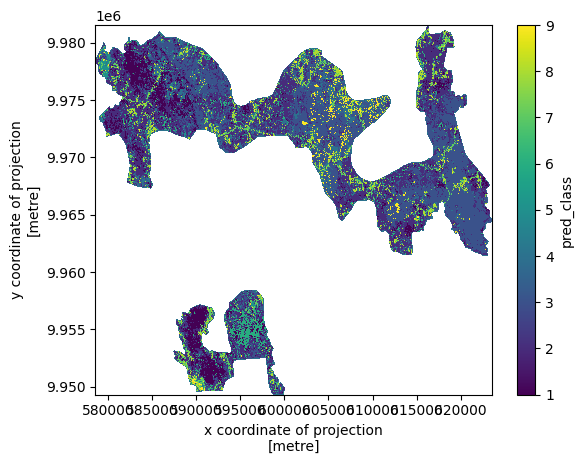

In [5]:
ds_lc_features.pred_class.plot.imshow()


In [13]:
# ds_tsfresh_features.y_pred.plot.imshow()

In [ ]:
# ### TESTING SAMPLE, FEATURE dim, its still works!
# tsfresh_pred_result = forestry.config['tsfresh_pred_result']
# lc_pred_result = forestry.config['lc_pred_result']

# ds_tsfresh_test = load_dataset_zarr(tsfresh_pred_result).drop_vars(['y_pred']).rename({'features':'feature'})
# preds_tsfresh_test, cx_tsfresh_test, cy_tsfresh_test = fc_infer.predict_dataset_features(
#     model_tsfresh,
#     ds_tsfresh_test,
#     cfg_tsfresh,
#     chunk_size=1000_000,
#     stack_grid=False,
# )
# ds_tsfresh_test['y_pred'] =('sample', preds_tsfresh_test)
# ds_tsfresh_test


## example array flatten , good to know, dont delete
# preds_lc
# ## flatten in np
# # if preds_lc.ndim == 2 and preds_lc.shape[1] == 1:
# #     pred_classes = preds_lc[:, 0]  # squeeze
# # elif preds_lc.ndim == 2 and preds_lc.shape[1] > 1:
# #     pred_classes = preds_lc.argmax(axis=1)  # if probs

# # pred_classes
# # or
# # pred_classes = preds_lc.reshape(-1)

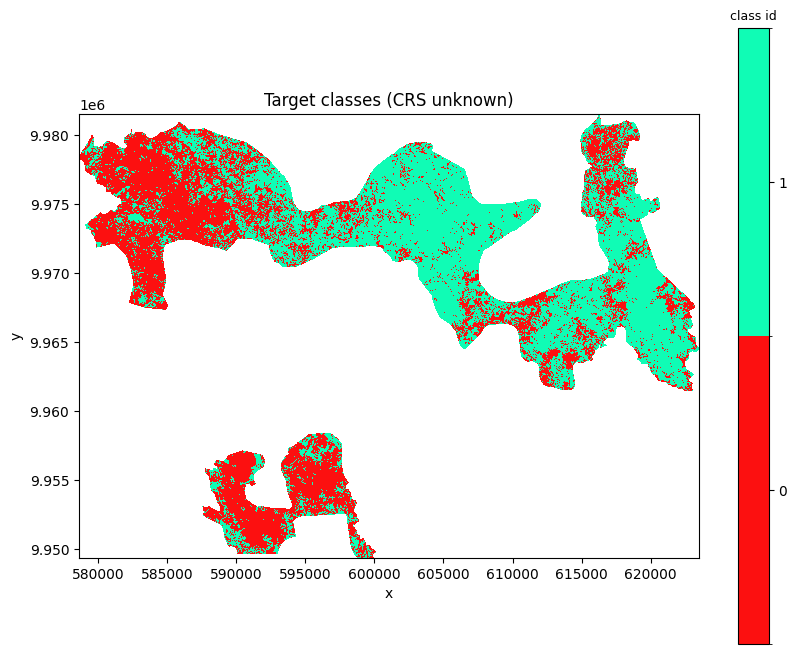

(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'Target classes (CRS unknown)'}, xlabel='x', ylabel='y'>)

In [ ]:
# from forestry_carbon_arr import plot_unstack_ds
import forestry_carbon_arr.ML.vis as fc_vis
importlib.reload(forestry_carbon_arr) 
importlib.reload(fc_vis)

## palette for tsfresh
palette_class_segment_tsfresh = {
    0: '#fc0303',   # not-eligible
    1: '#03fcb1'  # eligible
}

# Derived mapping ready for plot_unstack_ds(cmap_custom=...)
cmap_custom_tsfresh = {cid: hexcolor for cid, hexcolor in palette_class_segment_tsfresh.items()}
print("cmap_custom defined for classes tsfresh:", sorted(cmap_custom_tsfresh.keys()))

# plot_unstack_ds(ds_tsfresh_test,y=True,y_var='y_pred',cmap_custom=palette_class_segment_tsfresh)
fc_vis.plot_unstack_ds(ds_tsfresh_features,y=True,y_var='y_pred',cmap_custom=palette_class_segment_tsfresh, 
                stack_grid=True)

cmap_custom defined for classes landcover: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


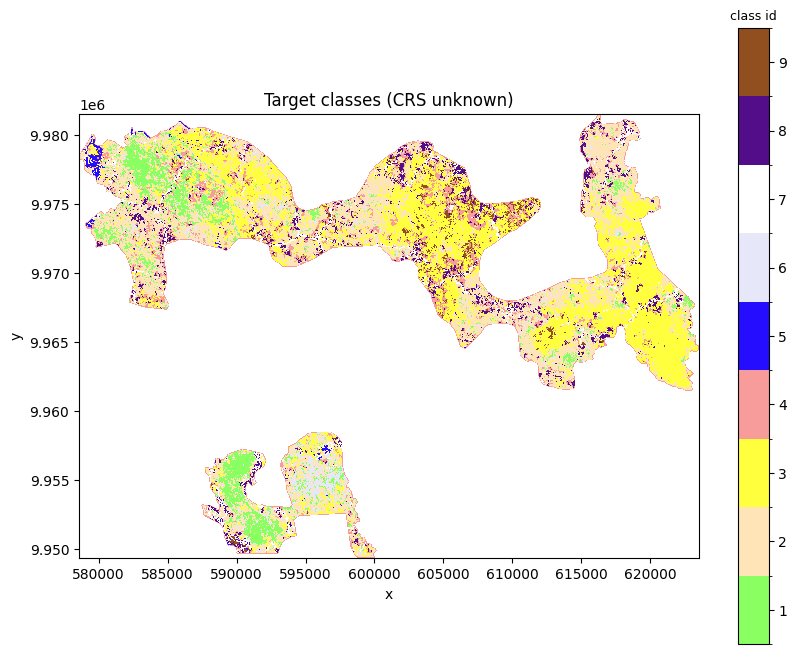

(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'Target classes (CRS unknown)'}, xlabel='x', ylabel='y'>)

In [22]:
# Custom palette for land-cover classes (1..14)
palette_class_segment_landcover = {
    1: '#83ff5a',   # forest_trees (1)
    2: '#ffe3b3',   # shrubland (2)
    3: '#ffff33',   # grassland (3)
    4: '#f89696',   # openland (4)
    5: '#1900ff',   # waterbody_waterlogged (5)
    6: '#e6e6fa',   # plantation (6)
    7: '#FFFFFF',   # gray_infrastructure (7)
    8: '#4B0082',   # oil_palm (8)
    9: '#8B4513',   # cropland (9)
    10: '#87CEEB',  # waterbody (10)
    11: '#2F4F4F',  # wetlands (11)
    12: '#ADFF2F',  # forest_trees_regrowth (12)
    13: '#8B0000',  # historical_treeloss_10years (13)
    14: '#DAA520',  # paddy_irrigated (14),
}

cmap_custom_landcover = {cid: hexcolor for cid, hexcolor in palette_class_segment_landcover.items()}
print("cmap_custom defined for classes landcover:", sorted(cmap_custom_landcover.keys()))

# plot_unstack_ds(ds_tsfresh_test,y=True,y_var='y_pred',cmap_custom=palette_class_segment_tsfresh)
fc_vis.plot_unstack_ds(ds_lc_features,y=True,y_var='pred_class',cmap_custom=cmap_custom_landcover, 
                stack_grid=True)

In [23]:
# if we want to alter the config later
# class_label_map = {
#                 1: 'forest_trees',
#                 2: 'shrubland',
#                 3: 'grassland',
#                 4: 'openland',
#                 5: 'waterbody_waterlogged',
#                 6: 'plantation',
#                 7: 'gray_infrastructure',
#                 8: 'oil_palm',
#                 9: 'cropland',
#                 # 10:'waterbody',
#                 # 14: 'paddy_irrigated',
#             }

# # Prepare configuration with unique hash
# # Note: We're using class_weights (set above using optimal_weights) to handle class imbalance
# #       This is more effective than sample weights for this use case
# cfg_lc['label_map'] = class_label_map

# X_features_list = ds_lc.feature.values

# cfg_lc['X_features_list'] = list(X_features_list)

# cfg_tsfresh['X_features_list'] = list(ds_tsfresh.features.values)

# local_cfg_path = save_config_ml(
#     cfg_tsfresh,
#     gcs_path=forestry.config['cbm_tsfresh_config']  # optional upload
# )
# print("Saved config to:", local_cfg_path)

In [24]:
# From the saved config
# print("label_map:", cfg_lc.get("label_map"))

In [33]:
## merging the ds but only extract the important columns (y_pred, pred_class)
import xarray as xr
# do first for el - tsfresh

## for stack_grid = False
# tsfresh_da= ds_tsfresh.y_pred
# ds_tsfresh_unstack = (
#     tsfresh_da.assign_coords(
#         coord_x=("sample", ds_tsfresh.coord_x.data),
#         coord_y=("sample", ds_tsfresh.coord_y.data),
#     )
#     .set_index(sample=("coord_y", "coord_x"))  # build MultiIndex on existing sample
#     .unstack("sample")                          # becomes dims coord_y, coord_x
#     .rename(coord_y="y", coord_x="x")
#     .rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=False)
#     .rio.write_crs(ds_tsfresh.rio.crs, inplace=False)
#     .to_dataset(name="el_tsfresh")
# )
# ds_tsfresh_unstack

## for stack_grid = True
tsfresh_da= ds_tsfresh_features.y_pred
ds_tsfresh_unstack = (
    tsfresh_da                    
    .rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=False)
    .rio.write_crs(forestry.config['output_crs'], inplace=False)
    .to_dataset(name="el_tsfresh")
)
# ds_tsfresh_unstack
lc_da= ds_lc_features.pred_class
ds_lc_unstack = (
    lc_da                    
    .rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=False)
    .rio.write_crs(forestry.config['output_crs'], inplace=False)
    .to_dataset(name="lc_class")
)

In [ ]:
import rasterio
import numpy as np
import pandas as pd
import forestry_carbon_arr.utils as utils
importlib.reload(utils)
from utils import convert_to_geotiff


# Export multiband GeoTIFF (numeric bands only) to GCS

convert_to_geotiff(
    ds_tsfresh_unstack,
    ['el_tsfresh'],
    output_path="gs://remote_sensing_saas/01-korindo/final_zone/tsfresh_el_test.tif",
    # class_name_map=class_name_map,  # Optional, for categorical encoding
)


Uploaded to gs://remote_sensing_saas/01-korindo/final_zone/tsfresh_el_test.tif


'gs://remote_sensing_saas/01-korindo/final_zone/tsfresh_el_test.tif'

In [35]:
## OVERLAY PROCESSING

from rasterio.enums import Resampling

# ds dataset to rio with crs
ds_tsfresh_unstack = ds_tsfresh_unstack.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=False)
ds_tsfresh_unstack = ds_tsfresh_unstack.rio.write_crs(forestry.config['output_crs'], inplace=False)
ds_lc_unstack = ds_lc_unstack.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=False)
ds_lc_unstack = ds_lc_unstack.rio.write_crs(forestry.config['output_crs'], inplace=False)

# Overlay processing
ds_overlay = ds_tsfresh_unstack.rio.reproject_match(ds_lc_unstack, resampling=Resampling.nearest)
merged = xr.merge([ds_overlay, ds_lc_unstack])

In [38]:
## testing the merge again
# merged["el_tsfresh"].plot.imshow()
# merged["lc_class"].plot.imshow()

In [39]:
## ZONE CLASS LOGIC
import numpy as np

#tsfresh = 0, then it is 10-years_deforestation_No-Go-Zone (ineligible)
#tsfresh = 1, then it is eligible, and mark the LC_Go-Zone

# eligibility land cover: in this class
list_lc_eligible_arr = [2,3,4,9]
list_lc_not_eligible_arr = [1,5,6,7,8]
#                 1: 'forest_trees',
#                 2: 'shrubland',
#                 3: 'grassland',
#                 4: 'openland',
#                 5: 'waterbody_waterlogged',
#                 6: 'plantation',
#                 7: 'gray_infrastructure',
#                 8: 'oil_palm',
#                 9: 'cropland'

# class_name_map = {
#     1: 'Forest_Trees_Go-Zone',
#     2: 'Shrubland_Go-Zone',
#     3: 'Grassland_Go-Zone',
#     4: 'Openland_Go-Zone',
#     5: 'Waterbody_No-Go-Zone',
#     6: 'Plantation_No_Go-Zone',
#     7: 'Infrastructure_No_Go-Zone',
#     8: 'Oil_Palm_No_Go-Zone',
#     9: 'Cropland_Go-Zone',
#     10: '10-years_deforestation_No-Go-Zone', #el tsfresh =0
#     }
## logic:
# find the lc in go zone based on list,
# if overlay with tsfresh = 0, then it is 10-years_deforestation_No-Go-Zone
# else if overlay with tsfresh = 1, then it is eligible, and mark the LC_Go-Zone

In [51]:
## IMPLEMENTATION

# 1 = eligible LC, 0 = not eligible LC
el_lc = xr.where(merged.lc_class.isin(list_lc_eligible_arr), 1, 0).rename("el_lc")
el_tsfresh = merged.el_tsfresh

# Eligible only if both are 1
cond = (el_lc == 1) & (el_tsfresh == 1)
nan_mask = el_lc.isnull() | el_tsfresh.isnull()

eligibility_arr = xr.where(nan_mask, np.nan, xr.where(cond, 1, 0)).rename("eligibility_arr")
# eligibility_arr

merged = merged.assign(el_lc=el_lc, eligibility_arr=eligibility_arr)
# merged

# Recreate zone_class (tsfresh + LC overlay)
# Rules:
# - tsfresh == 0 -> 10 (10-years deforestation No-Go)
# - tsfresh == 1 -> keep LC class codes 1..9

lc = merged.lc_class
el = merged.el_tsfresh
subtype_zone = xr.full_like(lc, np.nan, dtype=np.float32)

# tsfresh == 0 -> no-go code 10
subtype_zone = xr.where((el == 0) & (lc == 1), 1, subtype_zone) # exception, for forest and plantation only based on planet satellite
subtype_zone = xr.where((el == 0) & (lc == 6), 6, subtype_zone) # exception, for forest and plantation only based on planet satellite

subtype_zone = xr.where((el == 0) & (lc != 1) & (lc != 6), 10, subtype_zone) # exception, for forest and plantation only based on planet satellite

# tsfresh == 1 -> assign lc classes
for cls in [1,2, 3, 4, 5, 6, 7, 8, 9]:
    subtype_zone = xr.where((el == 1) & (lc == cls), cls, subtype_zone)

subtype_zone = subtype_zone.rename("subtype_zone")
# subtype_zone

# Create subtype_zone labels (string) from zone_class codes
class_name_map = {
    1: "Forest_Trees_Go-Zone",
    2: "Shrubland_Go-Zone",
    3: "Grassland_Go-Zone",
    4: "Openland_Go-Zone",
    5: "Waterbody_No-Go-Zone",
    6: "Plantation_No_Go-Zone",
    7: "Infrastructure_No_Go-Zone",
    8: "Oil_Palm_No_Go-Zone",
    9: "Cropland_Go-Zone",
    10: "10-years_deforestation_No-Go-Zone",
}

# subtype_zone_da = xr.apply_ufunc(
#     lambda v: class_name_map.get(int(v), np.nan) if np.isfinite(v) else np.nan,
#     subtype_zone,
#     vectorize=True,
#     dask="parallelized",
#     output_dtypes=[object],
# ).rename("subtype_zone")

subtype_zone_da = subtype_zone.rename("subtype_zone")
# subtype_zone_da

final_ds = merged.assign(subtype_zone=subtype_zone_da)
final_ds.attrs["subtype_zone"] = class_name_map
final_ds = final_ds.assign_attrs(crs=forestry.config['output_crs'])
final_ds

<xarray.Dataset> Size: 522MB
Dimensions:          (x: 4497, y: 3224)
Coordinates:
    spatial_ref      int64 8B 0
  * x                (x) float64 36kB 5.786e+05 5.786e+05 ... 6.235e+05
  * y                (y) float64 26kB 9.982e+06 9.982e+06 ... 9.949e+06
Data variables:
    el_tsfresh       (y, x) float64 116MB nan nan nan nan ... nan nan nan nan
    lc_class         (y, x) float64 116MB nan nan nan nan ... nan nan nan nan
    el_lc            (y, x) int64 116MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    eligibility_arr  (y, x) float64 116MB nan nan nan nan ... nan nan nan nan
    subtype_zone     (y, x) float32 58MB nan nan nan nan nan ... nan nan nan nan
Attributes:
    subtype_zone:  {1: 'Forest_Trees_Go-Zone', 2: 'Shrubland_Go-Zone', 3: 'Gr...
    crs:           EPSG:32749

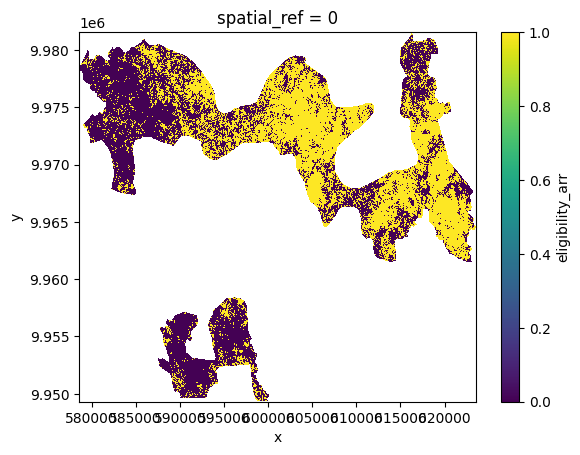

In [52]:
final_ds.eligibility_arr.plot.imshow()

In [53]:
np.unique(subtype_zone_da.values)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., nan],
      dtype=float32)

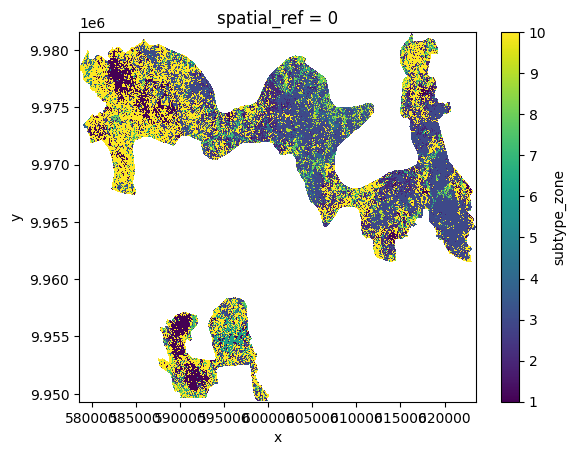

In [54]:
final_ds.subtype_zone.plot.imshow()


In [55]:
## TESTING before saving to zarr
convert_to_geotiff(
    final_ds,
    ['el_tsfresh', 'lc_class', 'el_lc', 'eligibility_arr', 'subtype_zone'],
    output_path="gs://remote_sensing_saas/01-korindo/final_zone/final_ds.tif",
    # class_name_map=class_name_map,  # Optional, for categorical encoding
     extra_attrs={"subtype_zone_map": class_name_map},
)

Uploaded to gs://remote_sensing_saas/01-korindo/final_zone/final_ds.tif


'gs://remote_sensing_saas/01-korindo/final_zone/final_ds.tif'

In [56]:
# ### SAVE THE DS
zarr_path = 'gs://remote_sensing_saas/01-korindo/final_zone/final_ds.zarr'
save_dataset_efficient_zarr(final_ds, zarr_path,overwrite=True, chunk_sizes={'x': 512, 'y': 512})

🗑️  Removing existing GCS zarr store: gs://remote_sensing_saas/01-korindo/final_zone/final_ds.zarr
📦 Saving to zarr: gs://remote_sensing_saas/01-korindo/final_zone/final_ds.zarr
   🌍 GEE-compatible format (Zarr v2)
   Dimensions: {'x': 4497, 'y': 3224}
   Chunks: {'x': 512, 'y': 512}
   Compression: lz4 (level 1)
   Zarr version: 2
   Consolidated metadata: True
   Storage: gcs


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:641: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"   Dimensions: {dict(ds.dims)}")
/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:710: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  dims = list(ds.dims.keys())


💾 Writing to zarr (with automatic parallelism)...


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:729: FutureWarning: zarr_version is deprecated, use zarr_format
  ds_chunked.to_zarr(


[########################################] | 100% Completed | 4.06 sms
✅ Dataset saved successfully!
   Store size: 10.39 MB
   Time: 8.9 seconds (0.1 minutes)
   Write speed: 1.2 MB/s
   Path: gs://remote_sensing_saas/01-korindo/final_zone/final_ds.zarr


'gs://remote_sensing_saas/01-korindo/final_zone/final_ds.zarr'

In [58]:
chunk_sizes = {'x': 512, 'y': 512, 'feature':-1}
save_dataset_efficient_zarr(ds_tsfresh_features, forestry.config['tsfresh_pred_result'],
                gee_compatible=False,
                overwrite=True, 
                chunk_sizes=chunk_sizes)

🗑️  Removing existing GCS zarr store: gs://remote_sensing_saas/01-korindo/tsfresh_model_catboost/ds_pred_results_tsfresh_aoi.zarr


📦 Saving to zarr: gs://remote_sensing_saas/01-korindo/tsfresh_model_catboost/ds_pred_results_tsfresh_aoi.zarr
   Dimensions: {'feature': 197, 'y': 3213, 'x': 4489}
   Chunks: {'x': 512, 'y': 512, 'feature': -1}
   Compression: None
   Zarr version: 2
   Consolidated metadata: True
   Storage: gcs


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:641: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"   Dimensions: {dict(ds.dims)}")


💾 Writing to zarr (with automatic parallelism)...


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:729: FutureWarning: zarr_version is deprecated, use zarr_format
  ds_chunked.to_zarr(


[                                        ] | 0% Completed | 188.06 ms

/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:729: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  ds_chunked.to_zarr(


[########################################] | 100% Completed | 4.65 ss
[########################################] | 100% Completed | 63.54 ss
✅ Dataset saved successfully!
   Store size: 7.31 GB
   Time: 78.2 seconds (1.3 minutes)
   Write speed: 95.7 MB/s
   Path: gs://remote_sensing_saas/01-korindo/tsfresh_model_catboost/ds_pred_results_tsfresh_aoi.zarr


'gs://remote_sensing_saas/01-korindo/tsfresh_model_catboost/ds_pred_results_tsfresh_aoi.zarr'

In [59]:
chunk_sizes = {'x': 512, 'y': 512, 'feature':-1}
save_dataset_efficient_zarr(ds_lc_features, forestry.config['lc_pred_result'],
                gee_compatible=False,
                overwrite=True, 
                chunk_sizes=chunk_sizes)

🗑️  Removing existing GCS zarr store: gs://remote_sensing_saas/01-korindo/planet_obia_arcgis/final_ds_pred_LC_20251207.zarr
📦 Saving to zarr: gs://remote_sensing_saas/01-korindo/planet_obia_arcgis/final_ds_pred_LC_20251207.zarr
   Dimensions: {'feature': 165, 'y': 3224, 'x': 4497}
   Chunks: {'x': 512, 'y': 512, 'feature': -1}
   Compression: None
   Zarr version: 2
   Consolidated metadata: True
   Storage: gcs


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:641: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"   Dimensions: {dict(ds.dims)}")


💾 Writing to zarr (with automatic parallelism)...


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:729: FutureWarning: zarr_version is deprecated, use zarr_format
  ds_chunked.to_zarr(


[##                                      ] | 5% Completed | 104.61 ms

/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:729: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  ds_chunked.to_zarr(


[########################################] | 100% Completed | 2.21 sms
[########################################] | 100% Completed | 14.59 ss
✅ Dataset saved successfully!
   Store size: 391.48 MB
   Time: 23.6 seconds (0.4 minutes)
   Write speed: 16.6 MB/s
   Path: gs://remote_sensing_saas/01-korindo/planet_obia_arcgis/final_ds_pred_LC_20251207.zarr


'gs://remote_sensing_saas/01-korindo/planet_obia_arcgis/final_ds_pred_LC_20251207.zarr'

In [ ]:
import xarray as xr
import numpy as np
from rasterio.transform import Affine


def unstack_from_ds_sample(ds, var="X_features", crs=None, transform=None, nodata=-9999):
    """Unstack a sample-based dataset back to y/x grid and return a Dataset."""
    da = ds[var].assign_coords(
        x=("sample", ds.coord_x.values),
        y=("sample", ds.coord_y.values),
    )

    da_grid = (
        da
        .set_index(sample=("y", "x"))
        .unstack("sample")
        .rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=False)
    )

    if crs is not None:
        da_grid = da_grid.rio.write_crs(crs, inplace=False)
    if isinstance(transform, Affine):
        da_grid = da_grid.rio.write_transform(transform, inplace=False)

    return da_grid.to_dataset(name=var)

# Example usage: provide real Affine if available
grid_ds = unstack_from_ds_sample(
    ds_ml_aoi_tsfresh,
    var="X_features",
    crs=ds_ml_aoi_tsfresh.attrs.get("crs"),
    transform=None,
)
grid_ds
